# Librerias y DataSet

## Librerias

In [1]:
# Imports
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Hyperparams
seed = 7

np.random.seed(seed)
tf.random.set_seed(seed)

## DataSet

### Acomodamiento del conjunto de datos

In [3]:
from glob import glob
from skimage import io

# Generacion del array de las imagnes
files = np.array(sorted(glob('data\\img\\*')))

# Generacion de las labels
labels = []

for file in files:
    if 'izq' in file:
        labels.append('izq')
    elif 'der' in file:
        labels.append('der')
    else:
        labels.append('cen')

labels = np.array(labels)

print(f'Cantidad de elementos en files -> {len(files)}')
print(f'Cantidad de elementos en labels -> {len(labels)}')

Cantidad de elementos en files -> 32
Cantidad de elementos en labels -> 32


Dimension de la imagen: (3000, 4000, 3)


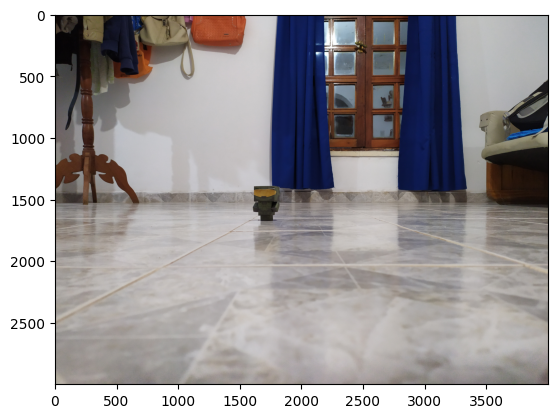

In [4]:
# Visualizacion rapida de las imagenes
image=io.imread(files[1])/255
print(f'Dimension de la imagen: {image.shape}')
plt.imshow(image,vmin=0,vmax=1)

### Split de los datos

In [5]:
from sklearn.model_selection import train_test_split

# Train/valid/test split
train_valid_files, test_files, train_valid_labels, test_labels = train_test_split(
    files, labels, test_size=0.2, random_state=1234, stratify=labels)
train_files, valid_files, train_labels, valid_labels = train_test_split(
    train_valid_files, train_valid_labels, test_size=0.25, random_state=5678, stratify=train_valid_labels)

print("Train: ", train_files.shape)
print("Valid: ", valid_files.shape)
print("Test: ", test_files.shape)

del train_valid_files, train_valid_labels

Train:  (18,)
Valid:  (7,)
Test:  (7,)


###  Construccion de los dataFrames

In [6]:
train_frame = pd.DataFrame(np.array([train_files, train_labels]).T, columns=['files','labels'])
valid_frame = pd.DataFrame(np.array([valid_files, valid_labels]).T, columns=['files','labels'])
test_frame = pd.DataFrame(np.array([test_files, test_labels]).T, columns=['files','labels'])

In [7]:
train_frame

,files,labels
0,data\img\izq (6).jpg,izq
1,data\img\der (6).jpg,der
2,data\img\izq (5).jpg,izq
3,data\img\cen (11).jpg,cen
4,data\img\izq (12).jpg,izq
5,data\img\cen (6).jpg,cen
6,data\img\cen (8).jpg,cen
7,data\img\cen (13).jpg,cen
8,data\img\der (2).jpg,der
9,data\img\izq (3).jpg,izq


In [8]:
test_frame

,files,labels
0,data\img\der (5).jpg,der
1,data\img\cen (12).jpg,cen
2,data\img\cen (3).jpg,cen
3,data\img\izq (1).jpg,izq
4,data\img\cen (2).jpg,cen
5,data\img\izq (9).jpg,izq
6,data\img\izq (2).jpg,izq


In [9]:
valid_frame

,files,labels
0,data\img\der (4).jpg,der
1,data\img\cen (7).jpg,cen
2,data\img\izq (8).jpg,izq
3,data\img\cen (10).jpg,cen
4,data\img\izq (10).jpg,izq
5,data\img\izq (7).jpg,izq
6,data\img\cen (9).jpg,cen


# Procesamiento de datos

In [10]:
from keras.preprocessing.image import ImageDataGenerator

# Rescalado o normalización de las  imagenes (0 a 1)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Creamos el iterador, indicando que y como vamos a leer los datos
train_iter = train_datagen.flow_from_dataframe(train_frame,
                                               x_col='files',
                                               y_col='labels',
                                               target_size=(100, 120),
                                               class_mode='categorical',
                                               batch_size=5,
                                               shuffle=True)

valid_iter = valid_datagen.flow_from_dataframe(valid_frame,
                                               x_col='files',
                                               y_col='labels',
                                               target_size=(100, 120),
                                               class_mode='categorical',
                                               batch_size=5,
                                               shuffle=False)

test_iter = test_datagen.flow_from_dataframe(test_frame,
                                             x_col='files',
                                             y_col='labels',
                                             target_size=(100, 120),
                                             class_mode='categorical',
                                             batch_size=5,
                                             shuffle=False)

Found 18 validated image filenames belonging to 3 classes.
Found 7 validated image filenames belonging to 3 classes.
Found 7 validated image filenames belonging to 3 classes.


In [11]:
print(test_iter.labels)
print(test_iter.filenames)

[1, 0, 0, 2, 0, 2, 2]
['data\\img\\der (5).jpg', 'data\\img\\cen (12).jpg', 'data\\img\\cen (3).jpg', 'data\\img\\izq (1).jpg', 'data\\img\\cen (2).jpg', 'data\\img\\izq (9).jpg', 'data\\img\\izq (2).jpg']


# Red Neuronal

## Modelado

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

# Modelado
model = Sequential()

# 1ra capa convolucional
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(100, 120, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2da capa convolucional
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Capa de aplanamineto o flatten
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(3, activation='softmax'))

# Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 116, 32)       2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 58, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 54, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 27, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 38016)             0         
                                                                 
 dense (Dense)               (None, 1024)              3

## Entrenamiento

In [13]:
# Compilación
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])

In [14]:
train_frame.shape[0]//train_iter.batch_size

3

In [15]:
# Ajuste
history = model.fit(train_iter, steps_per_epoch = train_frame.shape[0]//train_iter.batch_size,
                              epochs=25, validation_data=valid_iter,
                              validation_steps= valid_frame.shape[0]//valid_iter.batch_size)

Epoch 1/25
3/3 [==============================] - 3s 998ms/step - loss: 1.5346 - acc: 0.3077 - val_loss: 1.1106 - val_acc: 0.2000
Epoch 2/25
3/3 [==============================] - 2s 666ms/step - loss: 1.1070 - acc: 0.2308 - val_loss: 1.0841 - val_acc: 0.4000
Epoch 3/25
3/3 [==============================] - 2s 764ms/step - loss: 1.1285 - acc: 0.1538 - val_loss: 1.0777 - val_acc: 0.4000
Epoch 4/25
3/3 [==============================] - 2s 746ms/step - loss: 1.1208 - acc: 0.2308 - val_loss: 1.0675 - val_acc: 0.4000
Epoch 5/25
3/3 [==============================] - 2s 663ms/step - loss: 1.0598 - acc: 0.5385 - val_loss: 1.0540 - val_acc: 0.8000
Epoch 6/25
3/3 [==============================] - 2s 681ms/step - loss: 1.0279 - acc: 0.5385 - val_loss: 1.0433 - val_acc: 0.4000
Epoch 7/25
3/3 [==============================] - 2s 748ms/step - loss: 1.1249 - acc: 0.3846 - val_loss: 1.0538 - val_acc: 0.4000
Epoch 8/25
3/3 [==============================] - 2s 675ms/step - loss: 1.0901 - acc: 0.38

## Evaluacion

In [16]:
score = model.evaluate(valid_iter, steps= valid_frame.shape[0]//valid_iter.batch_size)
print("loss en validación: {} \naccuracy en validación: {}".format(score[0],score[1]))

score = model.evaluate(test_iter, steps= test_frame.shape[0]//test_iter.batch_size)
print("loss en test: {} \naccuracy en test: {}".format(score[0],score[1]))


1/1 [==============================] - 0s 387ms/step - loss: 1.0343 - acc: 0.4000
loss en validación: 1.0343250036239624 
accuracy en validación: 0.4000000059604645
1/1 [==============================] - 0s 403ms/step - loss: 1.0168 - acc: 0.4000
loss en test: 1.0168262720108032 
accuracy en test: 0.4000000059604645


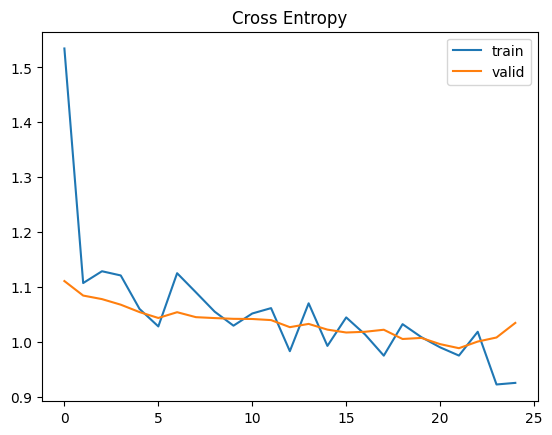

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','valid'])
plt.title('Cross Entropy')
plt.show()

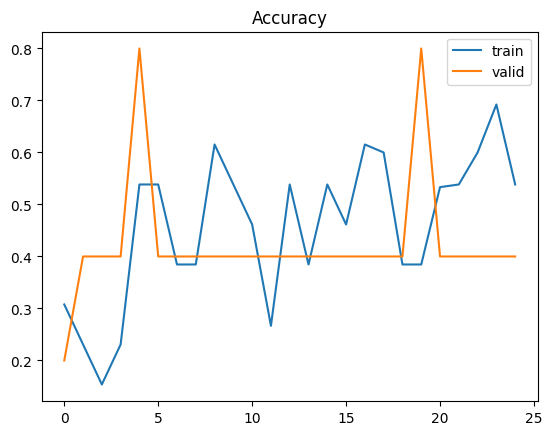

In [18]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['train','valid'])
plt.title('Accuracy')
plt.show()

## Prediccion

1/1 [==============================] - 0s 89ms/step


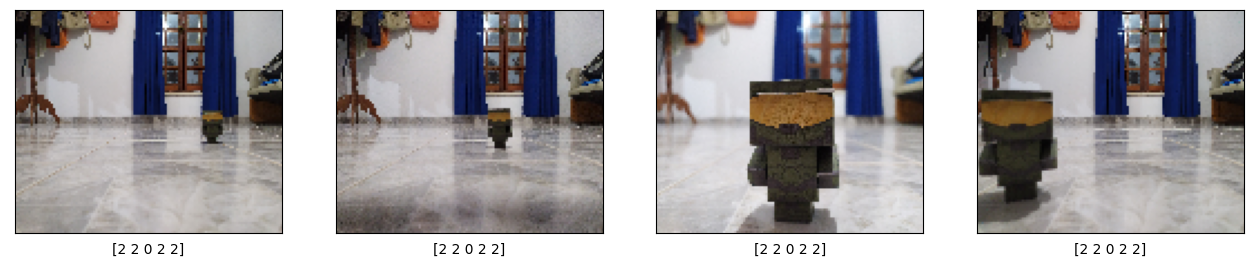

In [19]:
# accedemos al primer batch y nos quedamos solo con las imágenes
test_images = next(test_iter)[0]

# realizamos las predicciones
preds = model.predict(test_images)
pred_labels = np.argmax(preds, axis=1)

# Mostramos 5 imágenes del batch y las etiquetas asignadas.
fig = plt.figure(figsize=(20, 17))

for i in range(0,4):
    fig_i=fig.add_subplot(4,5, i+1)
    fig_i.imshow(test_images[i])

    fig_i.set_xticks(())
    fig_i.set_yticks(())

    fig_i.set_xlabel('%s' % pred_labels)

# Data augmentation

In [20]:
# Aplicando data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1./255,
                                             horizontal_flip = True,
                                             vertical_flip = True,
                                             rotation_range = 10)

In [21]:
# Se crea un nuevo iterador
train_iter_augmented = train_datagen_augmented.flow_from_dataframe(train_frame,
                                                                   x_col='files',
                                                                   y_col='labels',
                                                                   target_size=(100, 120),
                                                                   class_mode='categorical',
                                                                   batch_size=5,
                                                                   shuffle=True)

Found 18 validated image filenames belonging to 3 classes.


# Nueva iteracion

In [22]:
# Ajuste
history = model.fit(train_iter_augmented, steps_per_epoch = train_frame.shape[0]//train_iter.batch_size,
                              epochs=25, validation_data=valid_iter,
                              validation_steps= valid_frame.shape[0]//valid_iter.batch_size)

Epoch 1/25
3/3 [==============================] - 2s 927ms/step - loss: 1.0833 - acc: 0.3077 - val_loss: 1.0159 - val_acc: 0.4000
Epoch 2/25
3/3 [==============================] - 2s 668ms/step - loss: 1.0659 - acc: 0.6154 - val_loss: 1.0203 - val_acc: 0.6000
Epoch 3/25
3/3 [==============================] - 2s 664ms/step - loss: 1.0255 - acc: 0.6923 - val_loss: 1.0086 - val_acc: 0.4000
Epoch 4/25
3/3 [==============================] - 2s 675ms/step - loss: 1.0734 - acc: 0.3846 - val_loss: 0.9962 - val_acc: 0.4000
Epoch 5/25
3/3 [==============================] - 2s 698ms/step - loss: 1.0621 - acc: 0.4615 - val_loss: 1.0212 - val_acc: 0.4000
Epoch 6/25
3/3 [==============================] - 2s 656ms/step - loss: 1.1180 - acc: 0.2308 - val_loss: 1.0178 - val_acc: 0.8000
Epoch 7/25
3/3 [==============================] - 2s 675ms/step - loss: 1.0580 - acc: 0.5385 - val_loss: 1.0124 - val_acc: 0.8000
Epoch 8/25
3/3 [==============================] - 2s 654ms/step - loss: 1.0635 - acc: 0.38

In [23]:
# Evalucion
score = model.evaluate(valid_iter, steps= valid_frame.shape[0]//valid_iter.batch_size)
print("loss en validación: {} \naccuracy en validación: {}".format(score[0],score[1]))

score = model.evaluate(test_iter, steps= test_frame.shape[0]//test_iter.batch_size)
print("loss en test: {} \naccuracy en test: {}".format(score[0],score[1]))

1/1 [==============================] - 0s 393ms/step - loss: 1.0109 - acc: 0.4000
loss en validación: 1.0108890533447266 
accuracy en validación: 0.4000000059604645
1/1 [==============================] - 0s 402ms/step - loss: 0.7064 - acc: 0.8000
loss en test: 0.7064246535301208 
accuracy en test: 0.800000011920929


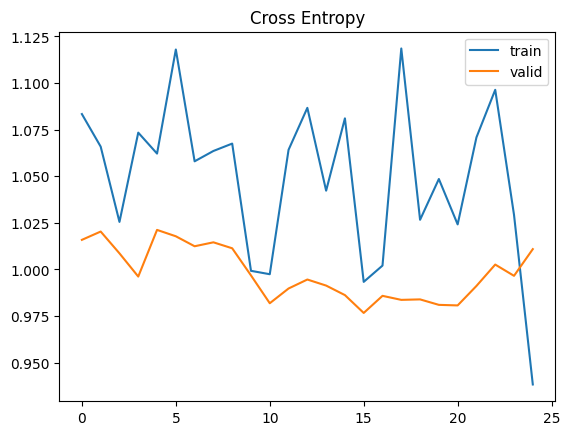

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','valid'])
plt.title('Cross Entropy')
plt.show()

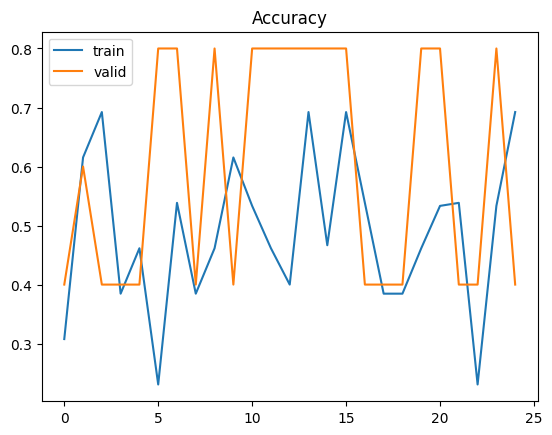

In [25]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['train','valid'])
plt.title('Accuracy')
plt.show()